In [1]:
import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tfe.enable_eager_execution()
import sys
sys.path.append(r'~/Pose-Estimation-Keras')
import cnn
from cnn import conv_base
from build_dataset import Dataset
import numpy as np
from sklearn.preprocessing import normalize
from scipy import stats

from keras import layers
from keras import models
from keras import optimizers
import keras.backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler

from time import time
import cv2
import os 


Using TensorFlow backend.
/home/bhandawatlab_duke/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [2]:
# Some Hyperparameters
total_frames = 5
frame_height = 224
frame_width = 224
frame_channels = 3
num_bodyparts = 6

In [3]:
def build_deconv_model():
    frame_tensor = conv_base.layers[0].get_input_at(0)
    resnet_output = cnn.convolution_network(frame_tensor)
    model_resnet = models.Model(inputs=[frame_tensor], outputs=[resnet_output])
    
    deconv_output = cnn.deconvolution_network(model_resnet.output)
    model_deconv = models.Model(inputs=[frame_tensor], outputs=[deconv_output])
    
    losses = {
        "deconvolution_network_output": "binary_crossentropy",
#         "spatial_fusion_output": "binary_crossentropy",
#         "optical_flow_output": "binary_crossentropy"
    }
    lossWeights = {"deconvolution_network_output": 1.0,}
#                    "spatial_fusion_output": 1.0,
#                    "optical_flow_output": 1.0}
    
#     opt = optimizers.SGD(lr = 0.0, momentum=0.9, nesterov=True)
    opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    model_deconv.compile( optimizer=opt, loss=losses, loss_weights=lossWeights, metrics = ["accuracy"])
    
    return model_deconv

model = build_deconv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 30)        552990    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 24)        6504      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 18)        3906      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 112, 112, 12)      1956      
_________________________________________________________________
deconvolution_network_output (None, 224, 224, 6)       654       
Total para

In [4]:
import csv
def parse_csv(file):
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        indices = []
        for line in csv_reader:
            indices.extend([int(f) for f in line if f!=''])
    return indices

indices = parse_csv('dataset_indices.csv')
print(indices)

[0, 2, 3, 4, 6, 7, 8, 11, 15, 16, 17, 18, 19, 20, 23, 120, 126, 127, 178, 185, 199, 228, 244, 261, 267, 285, 306, 335, 367, 375, 389, 405, 410, 415, 420, 426, 430, 436, 440, 445, 452, 455, 460, 465, 470, 476, 480, 485, 490, 496, 500, 511, 520, 525, 530, 535, 542, 552, 555, 568, 570, 575, 581, 588, 595, 600, 605, 610, 615, 621, 625, 633, 636, 640, 645, 650, 655, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 718, 723, 725, 751, 755, 770, 783, 784, 804, 812, 816, 823, 829, 838, 841, 845, 850, 855, 863, 865, 891, 894, 904, 908, 915, 920, 929, 946, 953, 955, 959, 965, 970, 980, 987, 990, 995, 1030, 1035, 1041, 1045, 1160, 1164, 1170, 1174, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1267, 1275, 1280, 1285, 1290]


In [5]:
import h5py
with h5py.File('../dataset.h5', 'r') as hf:
    central_heatmap = hf['central_heatmap'][indices]
    frames = hf['frames'][indices]
    heatmaps_individual = hf['heatmaps_individual'][indices]
    heatmaps_combined = hf['heatmaps_combined'][indices]

In [6]:
home_dir = os.getcwd()
central_heatmap = np.expand_dims(central_heatmap, axis=-1)
heatmaps_combined = np.expand_dims(heatmaps_combined, axis=-1)
heatmaps_individual = np.swapaxes(heatmaps_individual, 2, 4)
print(central_heatmap.shape)
print(heatmaps_individual.shape)
print(heatmaps_combined.shape)

(146, 6, 224, 224, 1)
(146, 5, 224, 224, 6)
(146, 5, 224, 224, 1)


In [7]:
heatmaps_individual[1].shape

(5, 224, 224, 6)

In [8]:
def step_decay(epoch):
    try:
        if epoch < 5:
            lrate = 0.01
        elif epoch < 70:
            lrate = 0.002
        elif epoch < 100:
            lrate = 0.0002
        elif epoch <= 120:
            lrate = 0.0001
        return lrate
    except:
        print('Error in setting learning rate')
        
lrate = LearningRateScheduler(step_decay, verbose=1)

checkpointer = ModelCheckpoint(filepath= os.path.join(home_dir, "pretrained_models/model010919.h5"),
                               verbose=1,
                               monitor='loss')

tensorboard = TensorBoard(log_dir=os.path.join(home_dir, "logs/{}".format(time())))


In [9]:
def normalize(x):
    x = np.array(x, dtype = np.float64)
    x -= np.mean(x, dtype = np.float64)
    x /= np.std(x, dtype = np.float64)
    return x


def generator(frames, heatmaps):
    while(1):
        for j,l in zip(frames, heatmaps):
#             print(l.shape[0])
            for channel in range(l.shape[0]):
                l[channel, :, :, :] = normalize(l[channel, :, :, :]) 
            # include batch dimension and repeat the matrix at axis 0 num_frames times to match the target dimensionality
            yield (j, {
#                 "optical_flow_output" : np.repeat(np.expand_dims(k, axis=0), 5, 0), 
                       "deconvolution_network_output": l}) 
            
model.fit_generator(generator(frames,
                                     heatmaps_individual),
                           steps_per_epoch=100, 
                           verbose = 2,
                           epochs = 150,
                           callbacks=[ checkpointer, tensorboard])

Epoch 1/150
 - 50s - loss: 0.5666 - acc: 0.6885

Epoch 00001: saving model to /home/bhandawatlab_duke/Pose-Estimation-Keras/pretrained_models/model010919.h5
Epoch 2/150
 - 37s - loss: 0.1635 - acc: 0.9691

Epoch 00002: saving model to /home/bhandawatlab_duke/Pose-Estimation-Keras/pretrained_models/model010919.h5
Epoch 3/150
 - 36s - loss: 0.0923 - acc: 0.9953

Epoch 00003: saving model to /home/bhandawatlab_duke/Pose-Estimation-Keras/pretrained_models/model010919.h5
Epoch 4/150
 - 36s - loss: 0.0797 - acc: 0.9953

Epoch 00004: saving model to /home/bhandawatlab_duke/Pose-Estimation-Keras/pretrained_models/model010919.h5
Epoch 5/150
 - 36s - loss: 0.0649 - acc: 0.9951

Epoch 00005: saving model to /home/bhandawatlab_duke/Pose-Estimation-Keras/pretrained_models/model010919.h5
Epoch 6/150
 - 36s - loss: 0.0558 - acc: 0.9949

Epoch 00006: saving model to /home/bhandawatlab_duke/Pose-Estimation-Keras/pretrained_models/model010919.h5
Epoch 7/150
 - 36s - loss: 0.0542 - acc: 0.9950

Epoch 000

In [10]:

import moviepy.editor as mpy

In [11]:
class PoseVideo:
    def __init__(self, path):
        self.path = path
        self.name = self.path.rsplit("\\")[-1].split(".")[0]
        self.clip = mpy.VideoFileClip(self.path).resize((224,224)) 
        self.predict_data = np.asarray(self.chop_video_into_frames(self.clip)[:-1])
        
    def chop_video_into_frames(self, clip, frames_per_chop=5):
        # gather all frames into a list
        frames = [x for x in clip.iter_frames()]
        
        # chop into pieces and save as 2D list
        frames_c = [frames[i * frames_per_chop:(i + 1) * frames_per_chop] for i in range((len(frames) + frames_per_chop - 1) // frames_per_chop )] 
        return frames_c
    

def heatmap_to_bodypart_location(heatmap):
    return np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)
    
def extract_central_frame(tensor):
    return tensor[0]

def predict_video(video):
    pass
    

In [12]:
test_video_path = r"/home/bhandawatlab_duke/deep-pose-predict/181023_1_12_video2.avi"
model_path = r"/home/bhandawatlab_duke/deep-pose/model_uno.h5"

vid_data = PoseVideo(test_video_path)

In [13]:
test_arr = model.predict_on_batch(vid_data.predict_data[1])

In [14]:
print(test_arr.shape)

(5, 224, 224, 6)


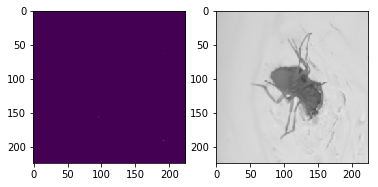

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
frame = 0
bp_no = 4
plt.subplot(121)
plt.imshow(test_arr[frame][ :, :, bp_no])

plt.subplot(122)
plt.imshow(vid_data.predict_data[1][frame])
